# Table of Contents:
0. [Introduction](#introduction)
1. [Detecting missing values](#detecting_missing_values)
2. [Analyzing the missingness](#analyzing_missingness)
3. [Dealing with missing values](#dealing_with_missing_values)
4. [Imputation techniques](#imputation_techniques)
5. [References](#references)

# Introduction:
In this notebook, I practice the techniques from the course [Dealing with Missing data in Python](https://app.datacamp.com/learn/courses/dealing-with-missing-data-in-python)

Broadly I cover the following topics:
1. Detecting missing values: None, NaN, np.nan and other **hidden** missing values
2. Analyzing the missingness:
   - Percentage
   - Correlation between missingness among different columns
   - Type of missingness: MCAR, MAR, MNAR
3. Dealing with missing values:
   - Dropping rows/columns
   - Imputation
4. Imputation techniques:
   - Simple imputation:
     - Univariate imputation
     - Eg: mean, median, mode(a.k.a. most frequent), constant 
   - Imputation using models:
     - Multivate imputation
     - Eg: KNN, MICE

In [2]:
import missingno as msno # msno matrix, bar, heatmap and dendrogram
import fancyimpute # KNN, MICE
from sklearn.impute import SimpleImputer # mean, median, most_frequent, constant
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import option_context

# Import dataset

In [3]:
df = pd.read_csv('../input/train.csv')

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [6]:
df.shape

(1460, 81)

## Note: 
1. read_csv has a parameter called `na_values`. We will use it later
2. We must not perform imputation on test dataset. 
   - **Reason**: You should never infer information from test dataset as that's an information leak.
   - **Solution**: Build a transformation pipeline that can handle all the necessary preprocessing steps (impute missing data, standardize, perform desired feature engineering, dimensionality reduction...) on training set and when a new observation comes (we should treat test set as just a new observations that are unavailable during training) apply this pipeline transformations on that new data.

# Detecting missing values:
Starting with simple missing values like None, NaN, np.nan and then moving on to hidden missing values.

For starters, it helps to check the nullity percentage of each column.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
nullity = df.isnull()

In [9]:
missing_values_sum = nullity.sum()

In [10]:
with option_context('display.max_rows', None):
    print(missing_values_sum.sort_values(ascending=False))

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
MasVnrType        872
FireplaceQu       690
LotFrontage       259
GarageYrBlt        81
GarageCond         81
GarageType         81
GarageFinish       81
GarageQual         81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
Electrical          1
Id                  0
Functional          0
Fireplaces          0
KitchenQual         0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
TotRmsAbvGrd        0
GarageCars          0
GrLivArea           0
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
BsmtFullBath        0
HeatingQC 

In [11]:
missing_values_sum = missing_values_sum[missing_values_sum > 0]

In [12]:
with option_context('display.max_rows', None):
    print(missing_values_sum.sort_values(ascending=False))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [13]:
missing_values_percentage = missing_values_sum / df.shape[0] * 100

In [14]:
missing_values_percentage.sort_values(ascending=False)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64

In [15]:
values = df.FireplaceQu.unique()
print(values)
print(type(values[0]))
print(df.Fireplaces.unique())

[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
<class 'float'>
[0 1 2 3]


In [16]:
values = df.PoolQC.unique()
print(values)
print(df.PoolArea.unique())

[nan 'Ex' 'Fa' 'Gd']
[  0 512 648 576 555 480 519 738]


Looking at the missing values percentages, I wanted to drop the columns instantly. But it's better to analyze the missingness before taking any action.

This [kaggle comment](https://www.kaggle.com/discussions/questions-and-answers/168308#936491) gives a good explanation of why we should not drop columns with high missingness.

For example, `FireplaceQu` has 47% missing values. But it's not because of missingness. It's because the house doesn't have a fireplace. So, it's not a missing value. It's just a value that's not applicable to that house. So, we should not drop it. This column is related to `Fireplaces` column.

Same logic applies to `PoolQC` column, which has nan values for houses that don't have a pool. This column is dependant on the `PoolArea` column. We can benefit from the PoolArea column to impute the missing values in `PoolQC` column

### A visual representation of missingness:

I found the following visual representation of missingness very useful. Refer to the [original notebook](https://www.kaggle.com/code/selahattinsanli/visualizing-missing-data) for more details.

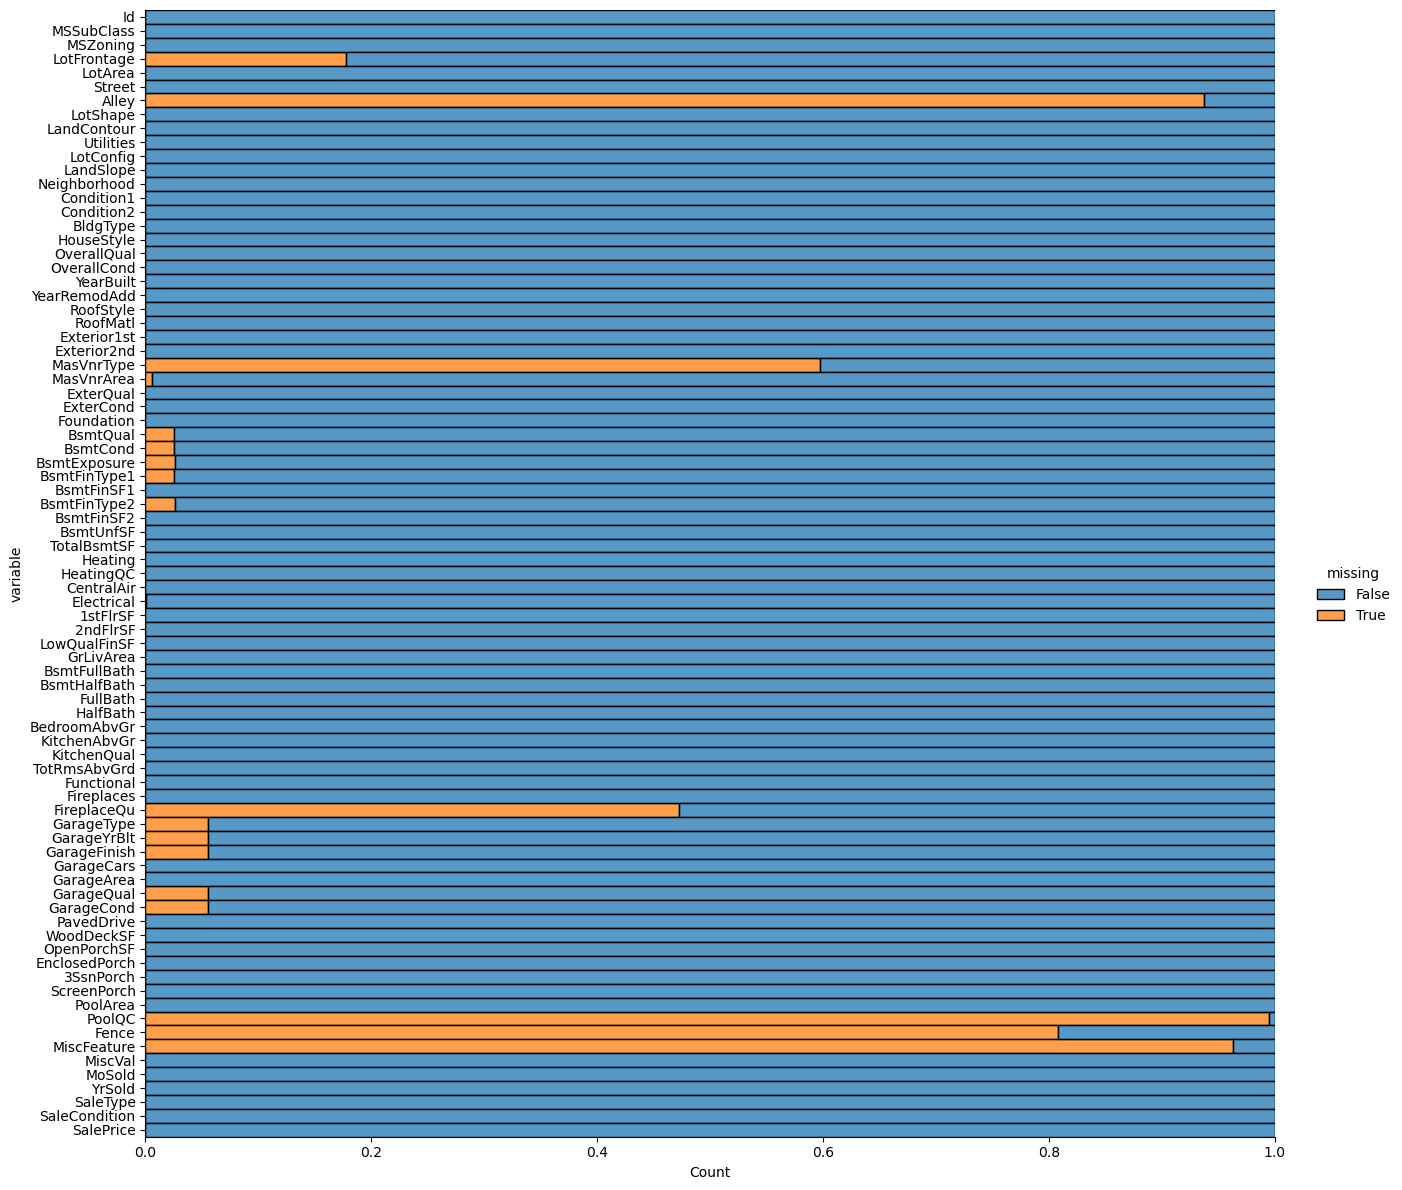

In [17]:
data = nullity.melt(value_name='missing')
data
sns.displot(
    data=data,
    y='variable',
    hue='missing',
    multiple='fill',
    height=12,
    aspect=1.1
)

### msno package:

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

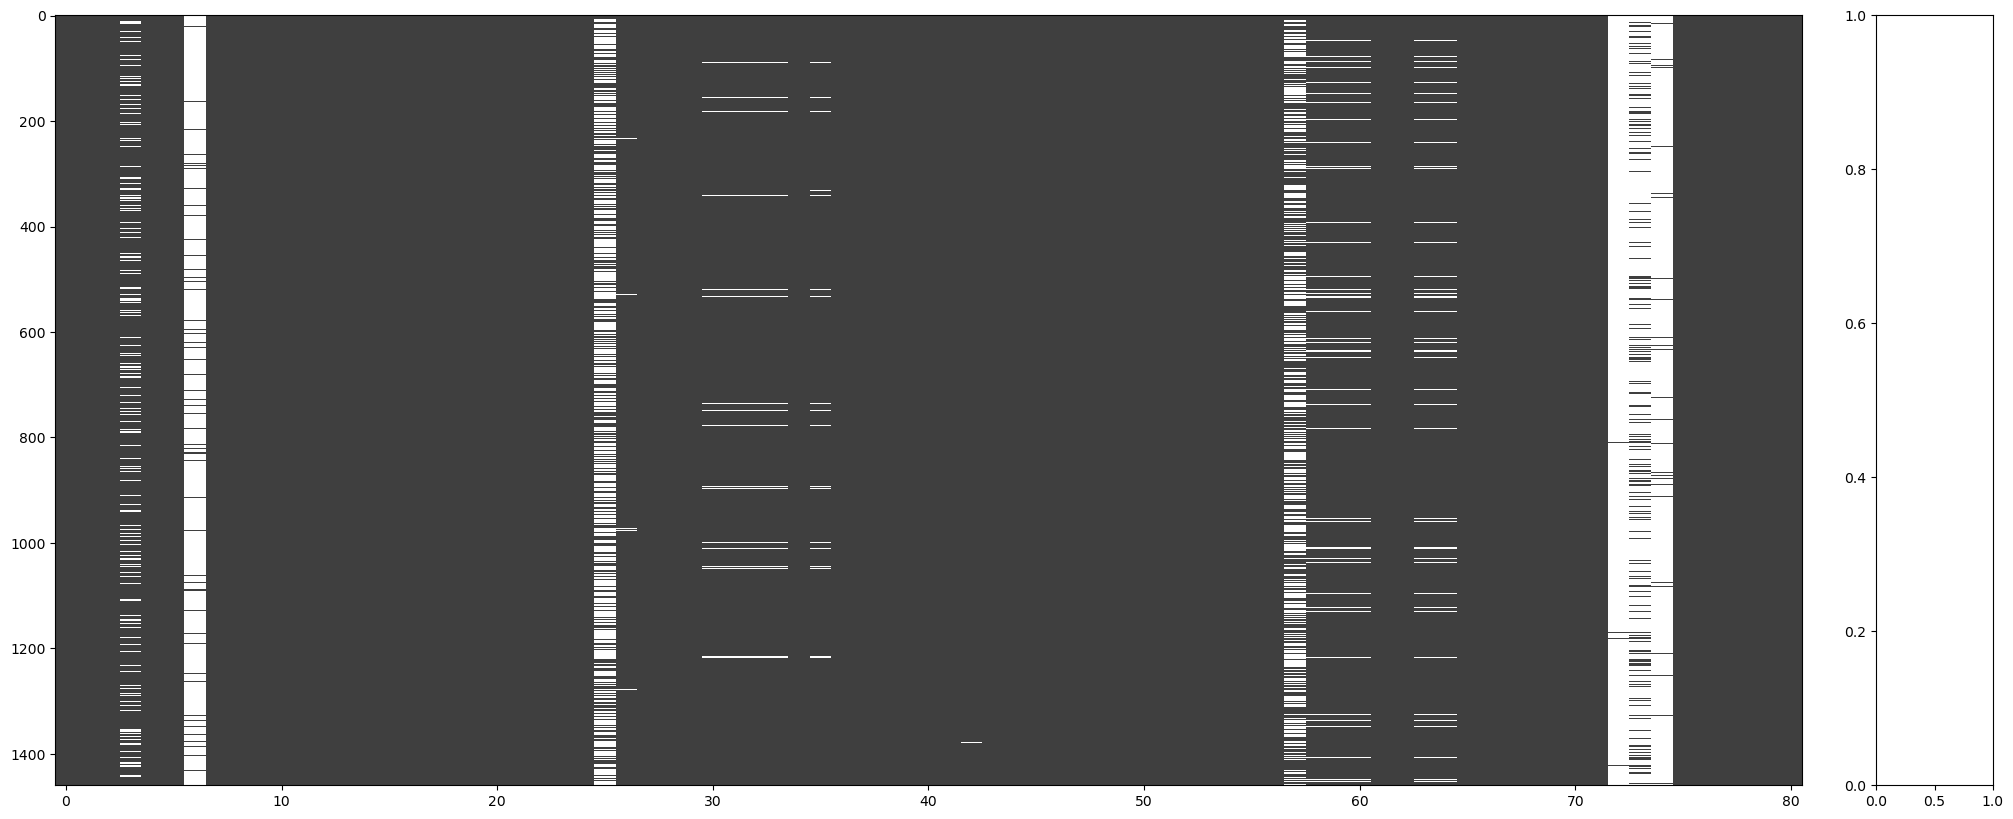

In [18]:
msno.matrix(df,labels=True)

<Axes: >

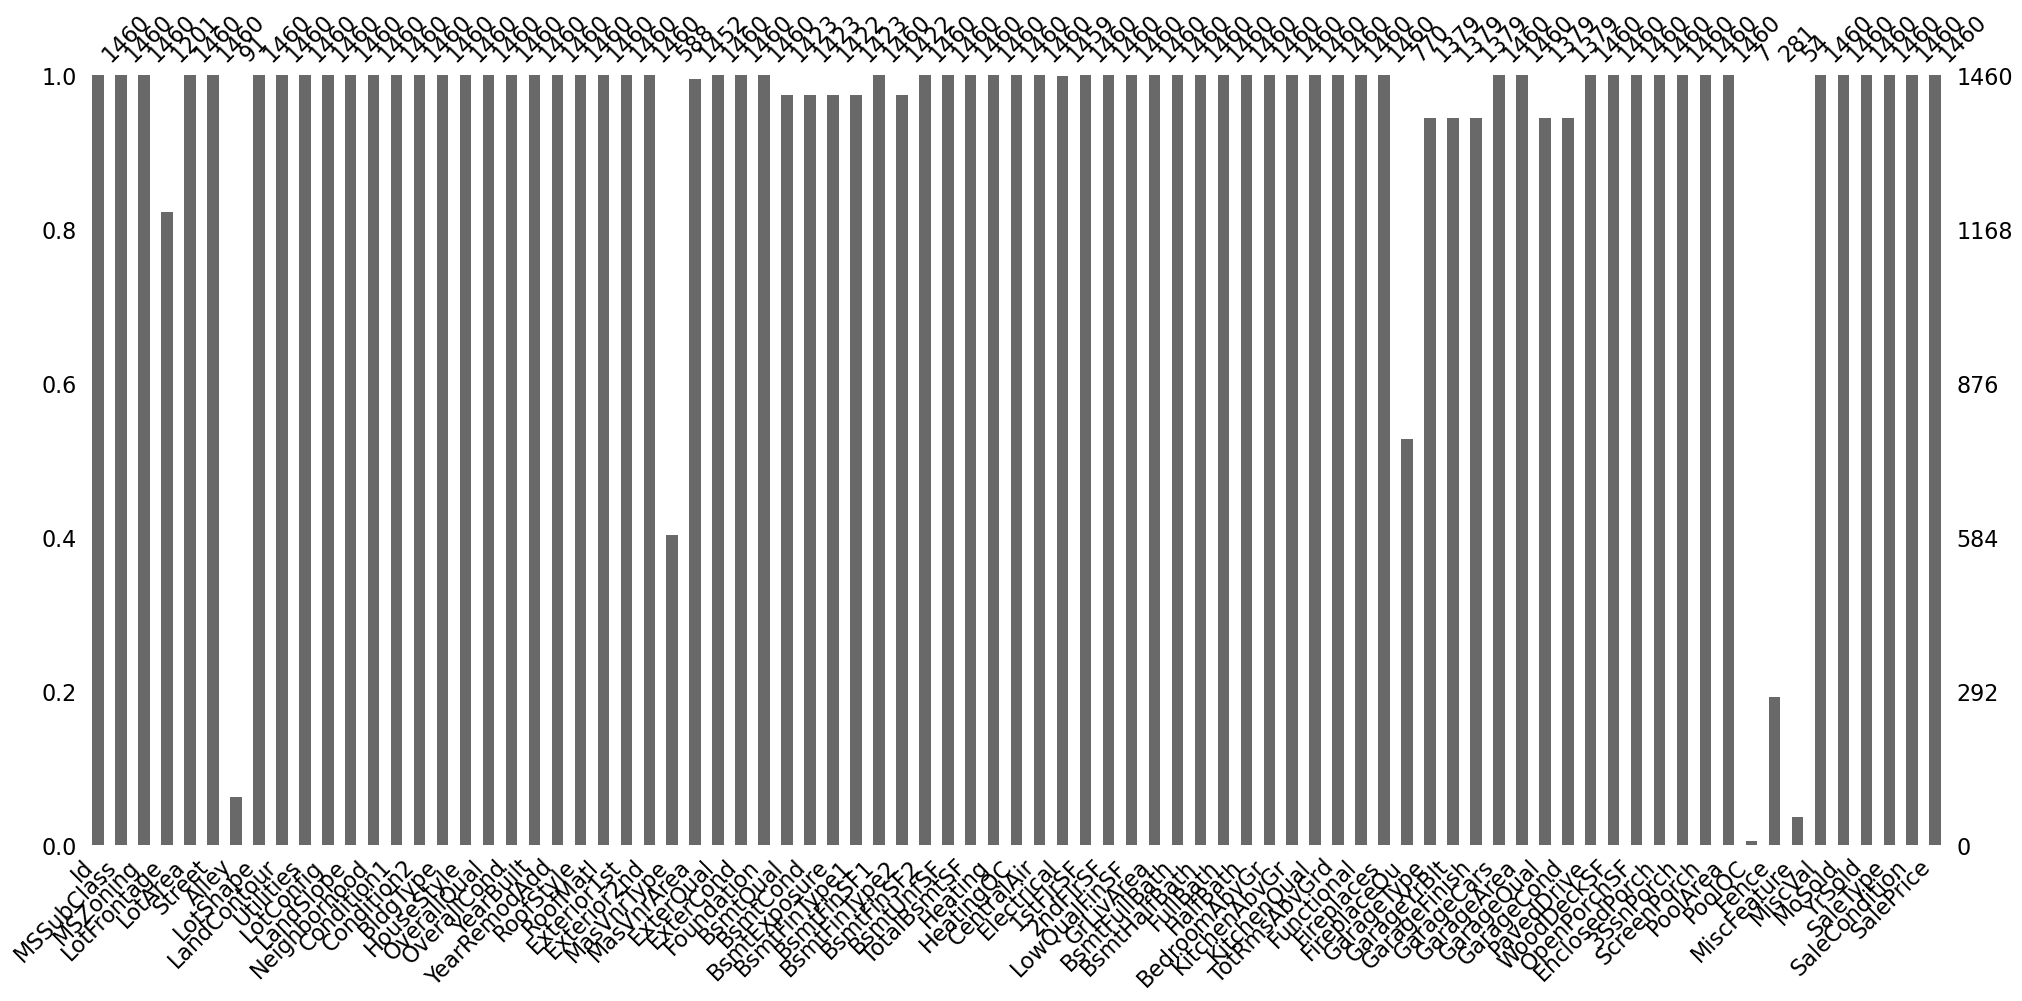

In [19]:
msno.bar(df,labels=True)

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

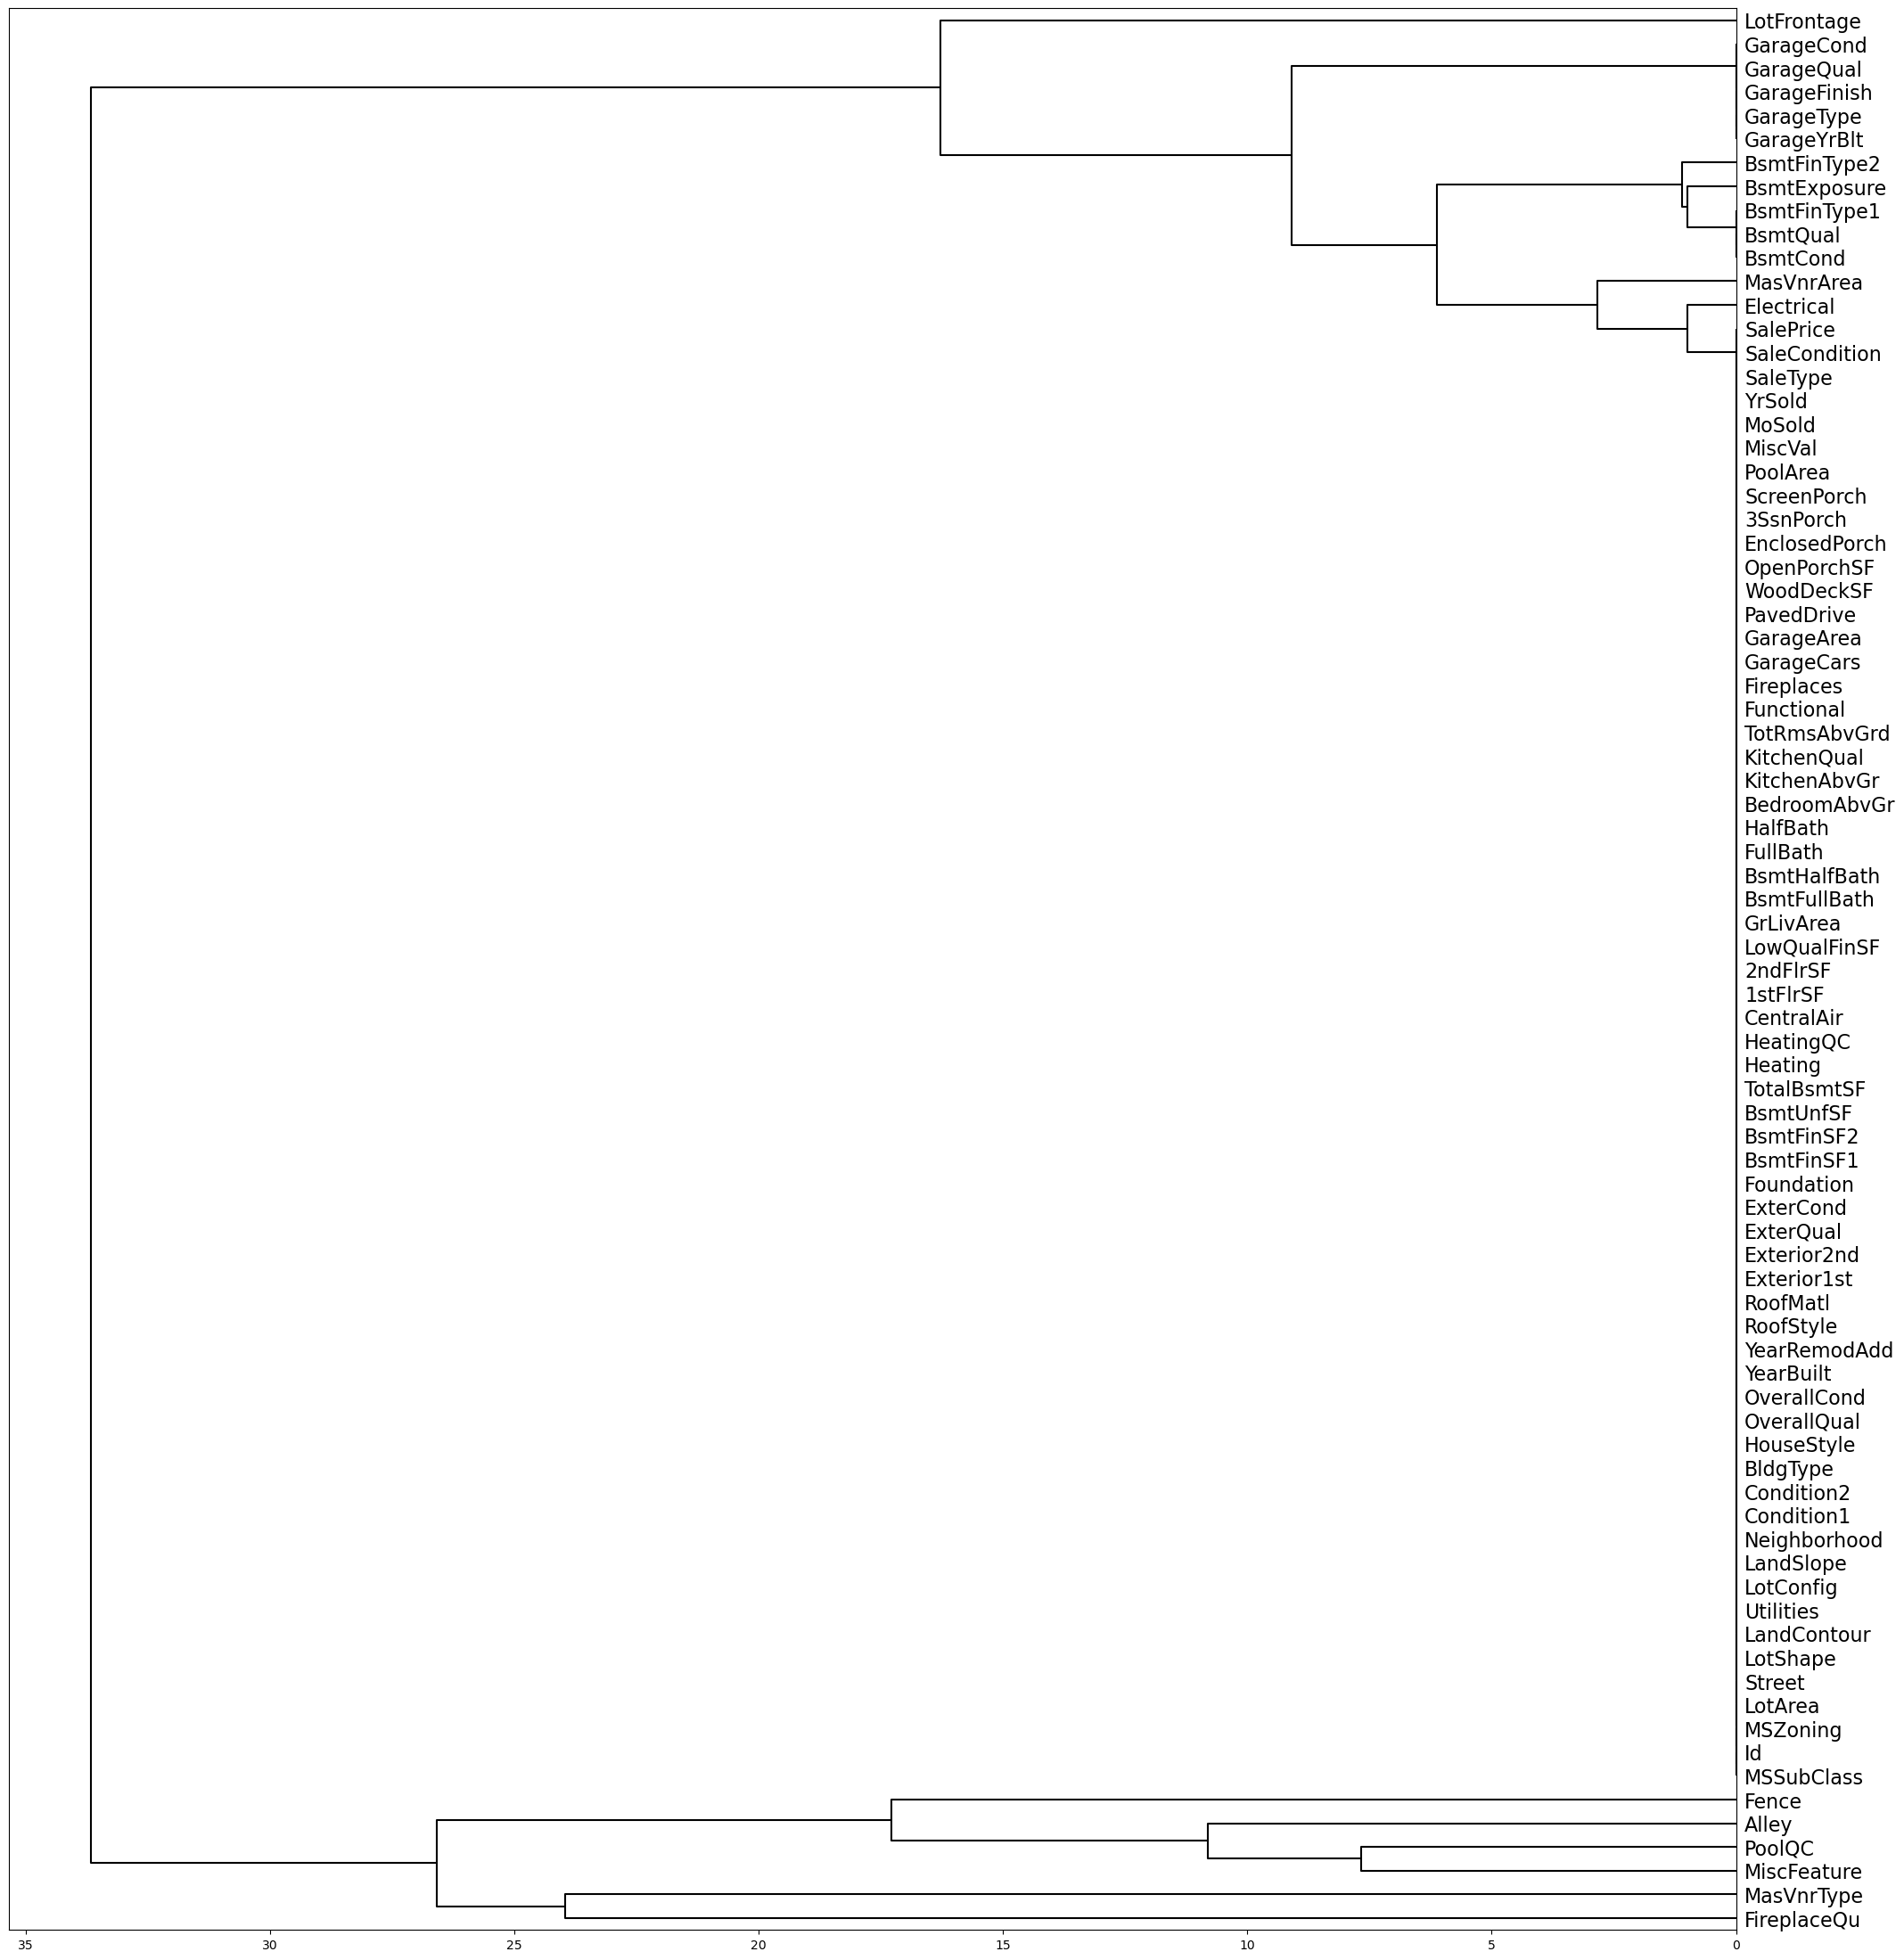

In [34]:
msno.dendrogram(df)

## Unhidden Missingness:

None, nan missing values are obvious. I will detect them first. I coined a term called **unhidden missingness** for these missing values.

I referred to the data_description.txt file to understand the columns.

### 1. PoolArea and PoolQC:
PoolArea: Pool area in square feet

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

The missingness is MNAR. The reason for nan values in PoolQC is because while importing data, the `na_values` parameter has default values to consider as missing values.

We can simply impute the missing values in PoolQC with 'No Pool' as the house doesn't have a pool.

### 2. MiscFeature:
 Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

Again, we can impute the missing values with 'None' as the house doesn't have any miscellaneous feature.

### 3. Alley: 
Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

We can impute the missing values with 'No alley access' as the house doesn't have any alley access.

### 4. Fence:
Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

We can impute the missing values with 'No Fence' as the house doesn't have any fence.

### 5. MasVnrType and MasVnrArea:
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	    None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet

We can impute the missing values in MasVnrType with 'None' as the house doesn't have any masonry veneer. 

In [39]:
df[df.MasVnrArea.isnull()][['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


### 6. FireplaceQu:
Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

We can impute the missing values with 'No Fireplace' as the house doesn't have any fireplace.

### 7. LotFrontage:
Linear feet of street connected to property

In [42]:
frontage = df['LotFrontage']

<Axes: ylabel='Frequency'>

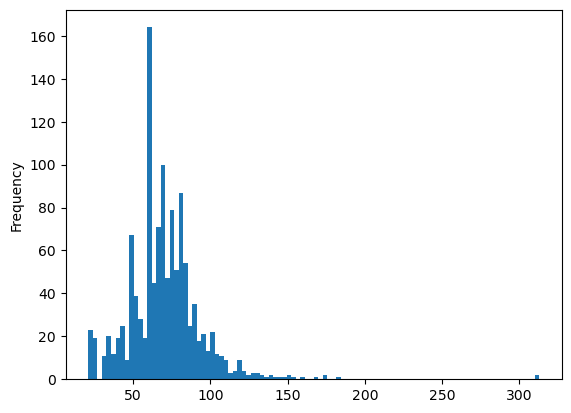

In [43]:
frontage.plot(kind='hist',bins=100)

### 8. GarageType, GarageFinish, GarageQual and GarageCond:
GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage

GarageFinish: Interior finish of the garage
              
       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

GarageCond: Garage condition

We can impute the missing values with 'No Garage' as the house doesn't have any garage.

### 9. GarageYrBlt
GarageYrBlt: Year garage was built

The imputation technique is not clear for now. I can't  impute the missing values with 0 as it represents the year of construction. Imputing with mean/median is also not a good idea as there is no garage built.

### 10. BsmtFinType2, BsmtExposure, BsmtFinType1, BsmtCond, BsmtQual:
Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches)
       NA	No Basement

### 11. Electrical:
Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

There is only 1 missing value. We can impute it with the most frequent value.

In [48]:
print(df.Electrical.unique())
print(df[df.Electrical.isnull()]['Electrical'])

['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
1379    NaN
Name: Electrical, dtype: object


In [49]:
with option_context('display.max_rows', None):
    print(missing_values_sum.sort_values(ascending=False))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


In [38]:
with option_context('display.max_rows', None):
    print(missing_values_percentage.sort_values(ascending=False))

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


## Hidden Missingness:

### 1. MSSubClass:

There can be 0 as a hidden missing value. But after observing the data, I found that there are no 0 values. So, we can leave it as it is.

**NOTE:** The data type is int64. But it's actually a categorical variable. So, we need to convert it to object type later

In [53]:
df.MSSubClass.sort_values().unique()

array([ 20,  30,  40,  45,  50,  60,  70,  75,  80,  85,  90, 120, 160,
       180, 190], dtype=int64)

### 2. 2ndFlrSF:
There are values=0 i.e., there is no 2nd floor. A boolean feature can be created to indicate whether the house has a 2nd floor or not.

In [80]:
df['2ndFlrSF'].sort_values().unique()

array([   0,  110,  167,  192,  208,  213,  220,  224,  240,  252,  272,
        299,  304,  316,  319,  325,  332,  336,  348,  349,  351,  358,
        368,  370,  371,  378,  384,  390,  403,  406,  408,  430,  432,
        438,  439,  441,  445,  448,  454,  455,  456,  457,  462,  464,
        467,  468,  472,  473,  475,  482,  495,  504,  510,  511,  512,
        514,  517,  518,  520,  521,  523,  524,  526,  527,  530,  533,
        534,  539,  540,  545,  546,  547,  548,  550,  551,  556,  557,
        560,  561,  564,  566,  567,  568,  571,  573,  574,  576,  580,
        581,  582,  584,  586,  587,  589,  590,  591,  592,  595,  596,
        600,  601,  602,  605,  611,  612,  620,  622,  623,  625,  626,
        628,  630,  631,  634,  636,  639,  640,  644,  648,  649,  650,
        651,  653,  656,  660,  661,  664,  665,  668,  670,  672,  676,
        677,  678,  679,  682,  684,  685,  686,  687,  688,  689,  691,
        694,  695,  698,  700,  701,  702,  703,  7

In [82]:
df['2ndFlrSF'].describe()

count    1460.000000
mean      346.992466
std       436.528436
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64

<Axes: ylabel='Frequency'>

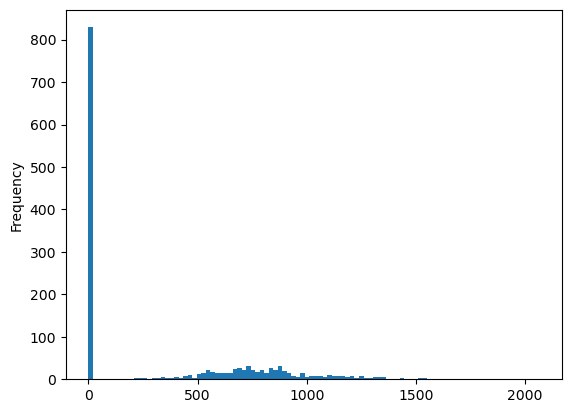

In [81]:
df['2ndFlrSF'].plot(kind='hist',bins=100)   

### 3. Other columns:
Some columns have value=0. They have corresponding categorical columns. For example, `MiscvVal` has mostly 0 because most of the houses don't have any miscellaneous feature.

In [99]:
df['MiscVal'].sort_values().value_counts()

MiscVal
0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
480         2
1200        2
1300        1
8300        1
3500        1
2500        1
1400        1
1150        1
800         1
54          1
620         1
560         1
350         1
15500       1
Name: count, dtype: int64

In [98]:
df['MiscVal'].describe()

count     1460.000000
mean        43.489041
std        496.123024
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64

<Axes: ylabel='Frequency'>

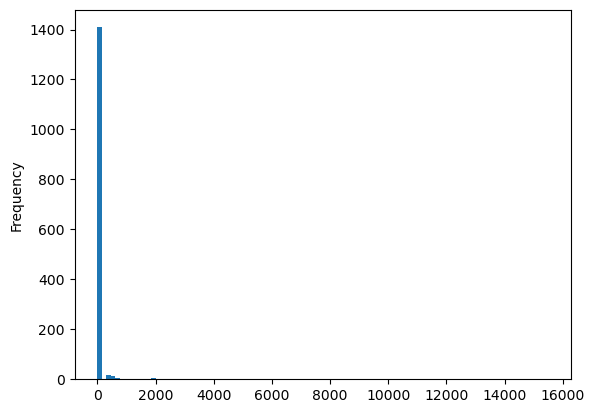

In [97]:
df['MiscVal'].plot(kind='hist',bins=100)   

# Dealing with missing values:
First, I will replace the nan values identified in the categorical columns with respective category. For example, nan values in `PoolQC` column will be replaced with 'No Pool'. 

In [ ]:
df['PoolQC'] = 